In [1]:
import sys
sys.path.append('segment_anything')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset
import os
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
import gc
import cv2
# 忽略所有警告
warnings.filterwarnings('ignore')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
seed_value = 42   # 设定随机数种子

np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)  # 为了禁止hash随机化，使得实验可复现。

torch.manual_seed(seed_value)     # 为CPU设置随机种子
torch.cuda.manual_seed(seed_value)      # 为当前GPU设置随机种子（只用一块GPU）
torch.cuda.manual_seed_all(seed_value)   # 为所有GPU设置随机种子（多块GPU）

torch.backends.cudnn.deterministic = True

class CFG:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    checpoint = 'result/segmentation_anthing_pretrain/sam_vit_l_0b3195.pth'
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # # comp_dir_path = './'
    # comp_dir_path = '/kaggle/input/'
    # comp_folder_name = 'vesuvius-challenge-ink-detection'
    # # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    # comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
        # comp_dir_path = './'
    comp_dir_path = ''
    comp_folder_name = 'data'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'SegAny_stride'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'SegAny'

    in_chans = 16# 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = 16
    use_amp = True

    epochs = 100 # 30

    # lr = 1e-4 / warmup_factor
    lr = 1e-5

    # ============== fixed =============
    pretrained = False

    backbone = 'se_resnext50_32x4d'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    num_workers = 4

    seed = 42

    threshhold = 0.5

    shape_list = []
    test_shape_list = []

    # ============== set dataset path =============

    # outputs_path = f'/kaggle/working/outputs/{comp_name}/{exp_name}/'
    outputs_path = 'result/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path
    log_dir = outputs_path + 'logs/'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


In [ ]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size + 1)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size + 1)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    label = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    label = np.pad(label, [(0, pad0), (0, pad1)], constant_values=0)

    label = label.astype('float32')
    label /= 255.0

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/mask.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0

    CFG.shape_list.append(mask.shape)
    
    return images, label, mask

def get_train_valid_dataset(val_persent=0.05):
    images = []
    labels = []
    positions = []
    indexs = []
    train_images = []
    train_labels = []

    valid_images = []
    valid_labels = []
    valid_positons = []

    index = 0

    for fragment_id in range(1, 4):

        image, label, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                if sum(list(mask[y1:y2, x1:x2].flatten())) != 0:
                    images.append(image[y1:y2, x1:x2])
                    labels.append(label[y1:y2, x1:x2, None])
                    positions.append([x1, y1, x2, y2, fragment_id - 1])
                    indexs.append(index)
                    index += 1
    random.shuffle(indexs)
    n = int(val_persent * len(indexs))
    train_indexs = indexs[:-n]
    for i, (image, label, position) in enumerate(zip(images, labels, positions)):
        if i in train_indexs:
            train_images.append(image)
            train_labels.append(label)
        else:
            valid_images.append(image)
            valid_labels.append(label)
            valid_positons.append(position)
    return train_images, train_labels, valid_images, valid_labels, valid_positons

def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)
    return aug

class SubvolumeDataset(data.Dataset):
    def __init__(self, images, labels, positions, transform, is_train):
        self.transform = transform
        self.images = images
        self.labels = labels
        self.is_train = is_train
        self.positions = positions
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        if self.is_train:
            image = self.images[index]
            label = self.labels[index]
            if self.positions:
                position = np.array(self.positions[index])
            else:
                position = np.zeros(1)
            if self.transform:
                data = self.transform(image=image, mask=label)
                image = data['image']
                label = data['mask']
            return image, label, position
        else:
            image = self.images[index]
            position = np.array(self.positions[index])
            if self.transform:
                data = self.transform(image=image, mask=label)
                image = data['image']
            return image, position
        
# IOU and Dice Score
def dice_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2 * inter + epsilon) / (den + epsilon)).mean()
    return dice


def iou_coef(y_true, y_pred, thr=0.5, dim=(0, 1), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true * y_pred).sum(dim=dim)
    iou = ((inter + epsilon) / (union + epsilon)).mean()
    return iou

In [ ]:
train_images, train_labels, valid_images, valid_labels, valid_positons = get_train_valid_dataset()

In [ ]:
train_dataset = SubvolumeDataset(train_images, train_labels, None,get_transforms(data='train', cfg=CFG), True)
valid_dataset = SubvolumeDataset(valid_images, valid_labels, valid_positons, get_transforms(data='valid', cfg=CFG), True)
train_loader = data.DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = data.DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [2]:
# model = Ringed_Res_Unet(n_channels=CFG.in_chans, n_classes=CFG.target_size).to(CFG.device)
# model = smp.UnetPlusPlus(in_channels=CFG.in_chans, classes=1, encoder_name=CFG.backbone).to(CFG.device)

# x = np.zeros((16, CFG.in_chans, 224, 224))
# x = torch.from_numpy(x).to(CFG.device).float()
# out = model(x)
# print(out.shape)
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
model = sam_model_registry["vit_l"](checkpoint=CFG.checpoint).cuda()
mask_generator = SamAutomaticMaskGenerator(model)
print(model)

model_name = CFG.model_name
if CFG.pretrained:
    try:
        checkpoint = torch.load(CFG.checpoint, map_location=CFG.device)
        models_dict = model.state_dict()
        for model_part in models_dict:
            if model_part in checkpoint:
                models_dict[model_part] = checkpoint[model_part]
        model.load_state_dict(models_dict)
        print('Checkpoint loaded')
    except:
        print('Checkpoint not loaded')
        pass

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate=none)
        )
      )
      (1): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bia

In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

32
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


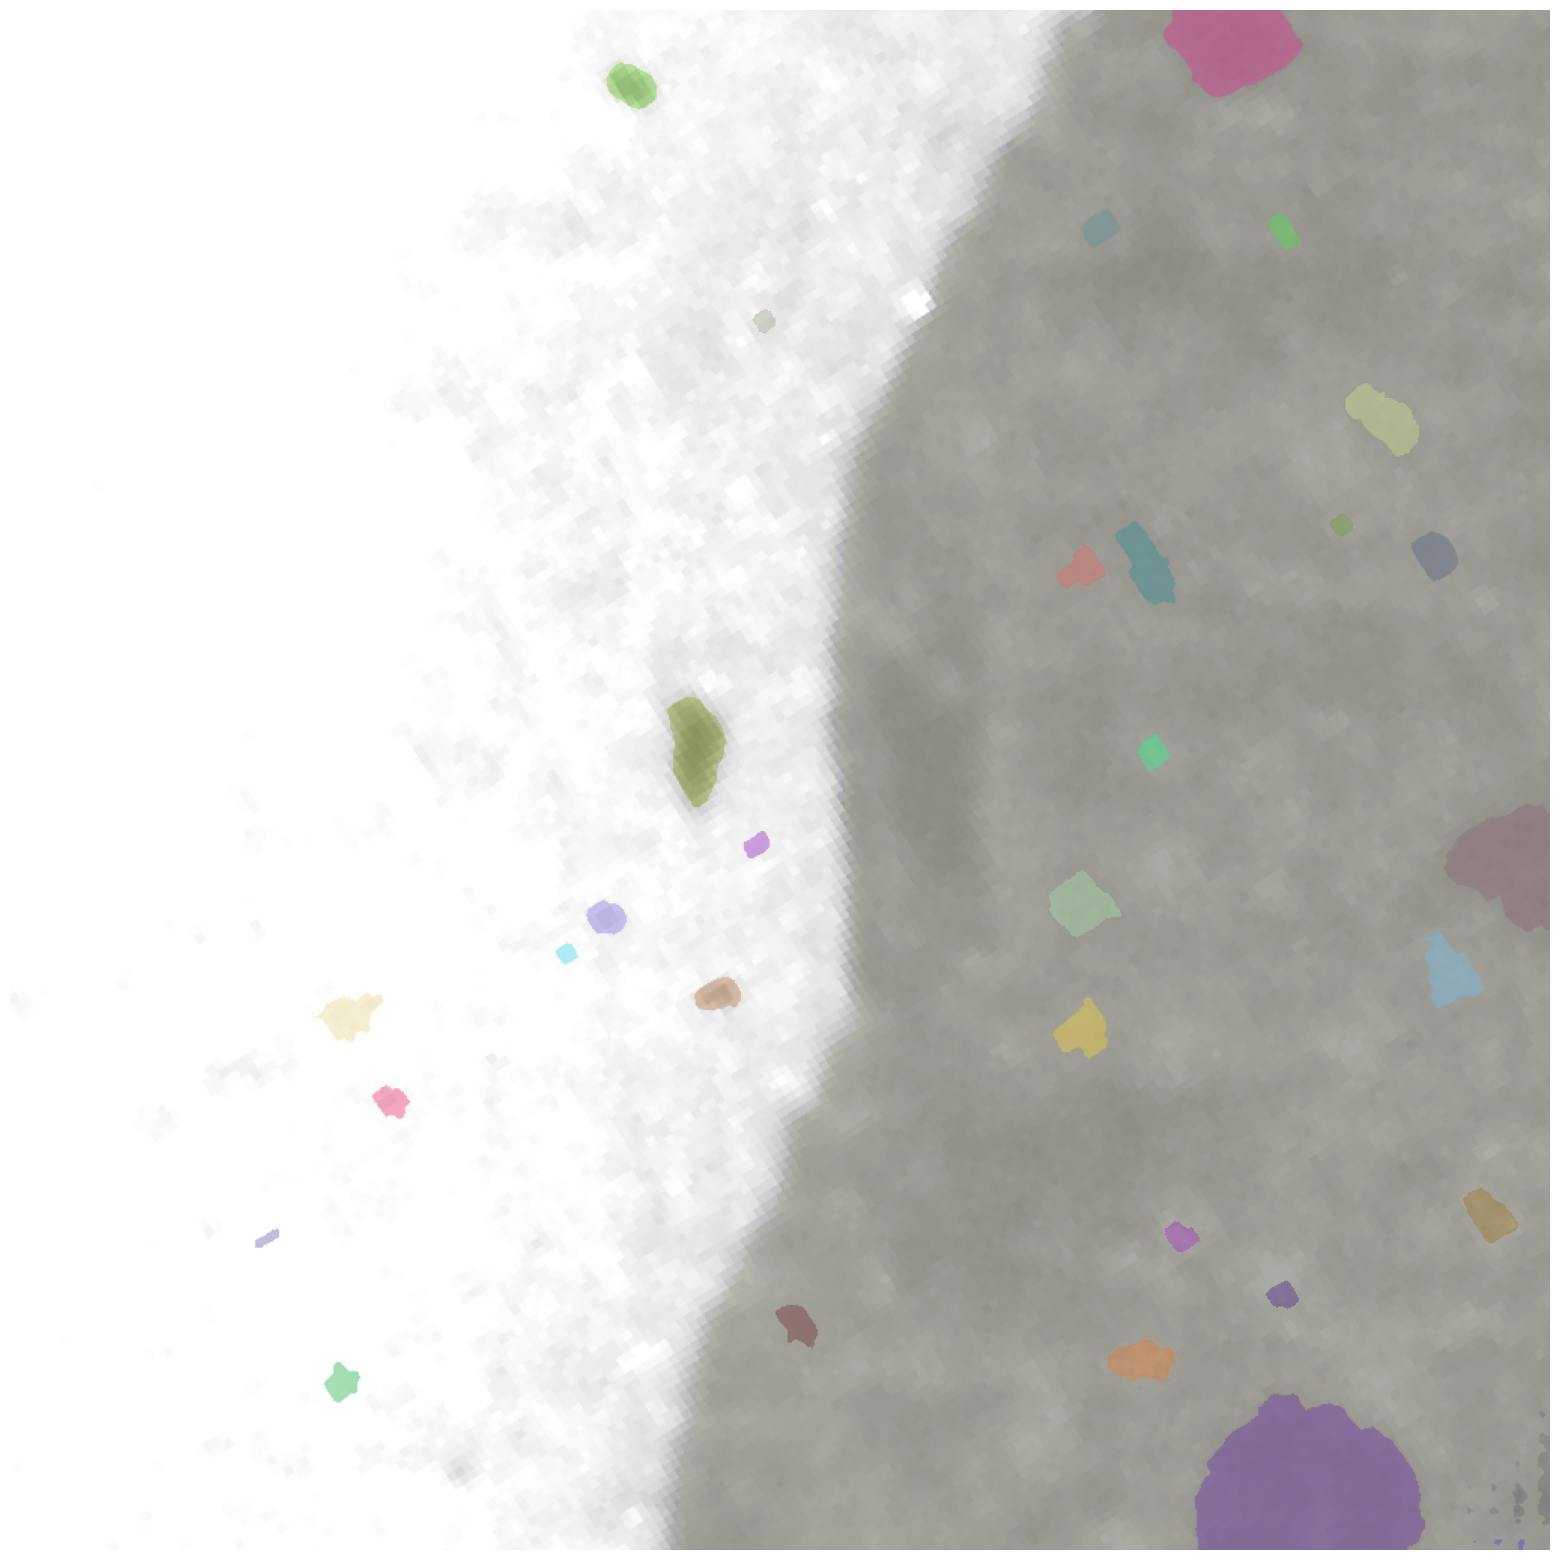

In [12]:
img = cv2.imread('data/train/3/ir.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)[1024:2048, 1024:2048, :]
# x = cv2.resize(x, [1024, 1024])
# x = torch.from_numpy(img).float().cuda().permute(2, 0, 1)
masks = mask_generator.generate(img)
print(len(masks))
print(masks[0].keys())
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
def train_step(train_loader, model, criterion, optimizer, writer, device, epoch):
    model.train()
    epoch_loss = 0
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * 10, eta_min=CFG.min_lr)
    bar = tqdm(enumerate(train_loader), total=len(train_loader)) 
    for step, (image, label, _) in bar:
        optimizer.zero_grad()
        outputs = model(image.to(device))
        loss = criterion(outputs, label.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        optimizer.step()
        scheduler.step()
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        bar.set_postfix(loss=f'{loss.item():0.4f}', epoch=epoch ,gpu_mem=f'{mem:0.2f} GB', lr=f'{optimizer.state_dict()["param_groups"][0]["lr"]:0.2e}')
        epoch_loss += loss.item()
    writer.add_scalar('Train/Loss', epoch_loss / len(train_loader), epoch)

def valid_step(valid_loader, model, criterion, device, writer, epoch):
    pred_label_list = []
    label_list = []
    for i in range(3):
        pred_label_list.append(torch.zeros(CFG.shape_list[i]))
        label_list.append(torch.zeros(CFG.shape_list[i]))
    model.eval()
    epoch_loss = 0
    dice_scores = []
    iou_scores = []

    for step, (images, labels, positions) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # make whole mask
        y_preds = torch.sigmoid(y_preds)
        pred_img = (y_preds > CFG.threshhold).float()
        positions = positions.squeeze()
        for i in range(len(positions)):
            x1, y1, x2, y2, fragment_id = positions[i].numpy().tolist()
            pred_label_list[fragment_id][y1:y2, x1:x2] = pred_img[i].squeeze(0).cpu()
            label_list[fragment_id][y1:y2, x1:x2] = labels[i].squeeze(0).cpu()
        epoch_loss += loss.item()
        # 计算准确率
        dice_score = dice_coef(labels.to(device), y_preds.to(device), thr=CFG.threshhold).item()
        iou_socre = iou_coef(labels.to(device), y_preds.to(device), thr=CFG.threshhold).item()

        dice_scores.append(dice_score)
        iou_scores.append(iou_socre)
                
    # 使用make_grid将图片转换成网格形式
    for i in range(len(pred_label_list)):

        pred_mask = make_grid(pred_label_list[i], normalize=True)
        true_mask = make_grid(label_list[i], normalize=True)
        # 使用add_image方法将图片添加到TensorBoard中
        writer.add_image('Valid/' + str(i) + '_True_mask', true_mask, global_step=epoch, dataformats="CHW")
        writer.add_image('Valid/' + str(i) + '_Pred_mask', pred_mask, global_step=epoch, dataformats="CHW")

    writer.add_scalar('Val/IOU', sum(iou_scores) / len(iou_scores), epoch)
    writer.add_scalar('Val/Dice', sum(dice_scores) / len(dice_scores), epoch)
    writer.add_scalar('Valid/Loss', epoch_loss / len(valid_loader), epoch)
    torch.save(model.state_dict(), 'result/' +  '{}-DIM-{}-[eval_loss]-{:.4f}-[dice_score]-{:.2f}-[iou_score]-{:.2f}-'.format(model_name, CFG.in_chans , epoch_loss / len(valid_loader), sum(dice_scores) / len(dice_scores), sum(iou_scores) / len(iou_scores)) + str(epoch) + '-epoch.pkl')

In [ ]:
criterion = smp.losses.SoftBCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=CFG.lr,
                        betas=(0.9, 0.999),
                        weight_decay=CFG.weight_decay
                        )
writer = SummaryWriter('result/logs')
for i in range(CFG.epochs):
    print('train:')
    train_step(train_loader, model, criterion, optimizer, writer, CFG.device, i + 1)
    print('val:')
    valid_step(valid_loader, model, criterion, CFG.device, writer, i + 1)